In [1]:
import time
import sklearn.linear_model
from sklearn.datasets import fetch_openml
import sys
import numpy as np
# np.set_printoptions(threshold=sys.maxsize)

In [2]:
mnist = fetch_openml('mnist_784', version=1)

/Users/zivlazarov/miniforge3/envs/tensorflow-env/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
X.iloc[0, -3:-1]

pixel782    0.0
pixel783    0.0
Name: 0, dtype: float64

In [6]:
# setting pixel values to be in [0, 1] range
# X = X/255.0

In [7]:
#columns = list(X.columns)

In [8]:
#new_columns = ['bias']

In [9]:
# new list for the dataframe's columns
#new_columns.extend(columns)

In [10]:
# creating the bias column
#X['bias'] = 1

In [11]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# reordering the dataframe with the first column to be the bias
#X = X[new_columns]

In [13]:
#X.head()

In [14]:
# getting the correct shape
X.shape

(70000, 784)

In [15]:
y.shape

(70000,)

In [16]:
y.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [17]:
# working with integers instead of strings for convenience
y = y.apply(lambda x : int(x))

In [18]:
y.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, int64): [0, 1, 2, 3, ..., 6, 7, 8, 9]

In [19]:
X, y = X.to_numpy(), y.to_numpy()

In [20]:
import matplotlib.pyplot as plt

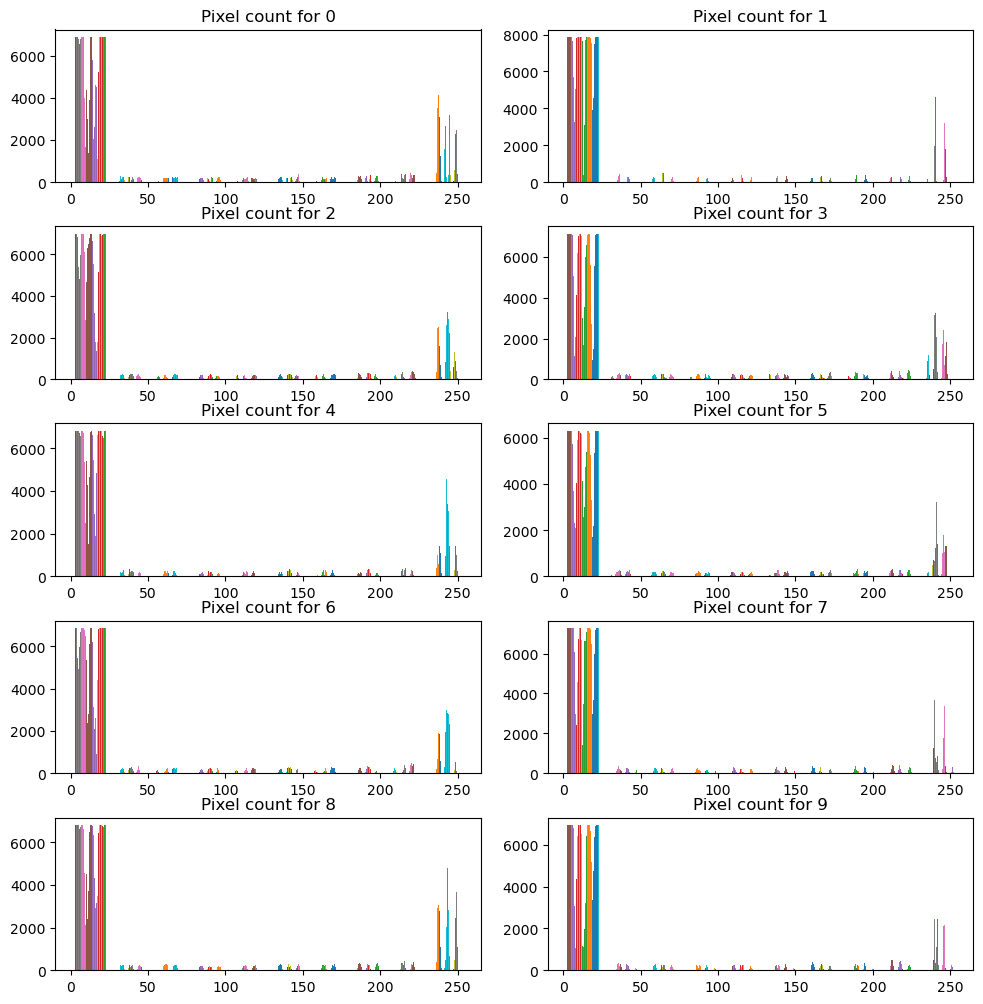

In [21]:
# showing distribution of pixels for every digit
fig, ax = plt.subplots(5, 2, figsize=(10, 10))
fig.tight_layout()
for i in range(len(np.unique(y))):
    ax[i//2, i%2].hist(X[np.where(y == i)][:, :])
    ax[i//2, i%2].set_title(f'Pixel count for {i}')

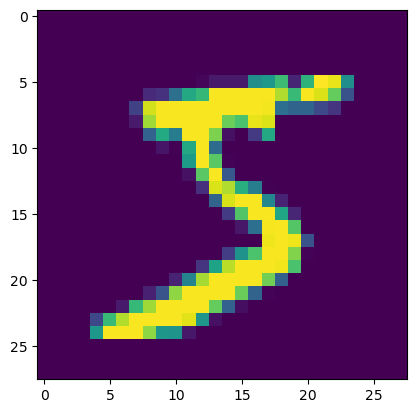

In [22]:
# getting an idea of an image
plt.imshow(X[0, :].reshape(28, 28))

(array([6903., 7877., 6990., 7141., 6824., 6313., 6876., 7293., 6825.,
        6958.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

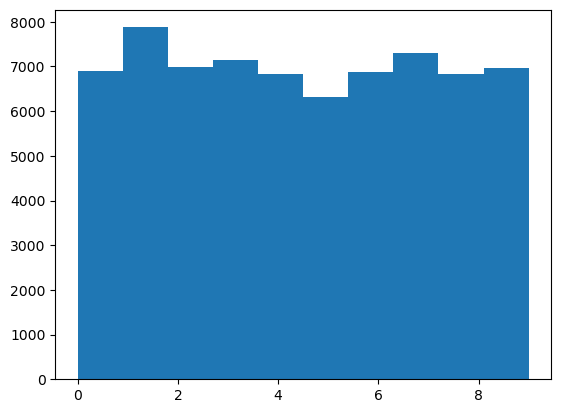

In [23]:
# check distribution of each digit
plt.hist(y)

In [24]:
# adding the bias column as the first column
X = np.concatenate((np.ones(shape=(X.shape[0],))[:, np.newaxis], X), axis=1)

In [25]:
np.unique(X[:, 0])

array([1.])

In [26]:
X.shape

(70000, 785)

In [27]:
class Perceptron:

    def __init__(self, num_features, classes, epochs=1):
        # num_features includes the extra bias column with the dataset so we'll add it
        self.num_features = num_features
        # values of the multi-class labels
        self.classes = classes
        self.num_classes = len(self.classes)
        self.num_samples = 0
        self.epochs = epochs
        
        # initializing the weights vector for every class with values [-1, 1]
        self.weights = np.random.uniform(low=-1, high=1, size=(self.num_classes, self.num_features))
        # weight vectors for pocketing
        self.final_weights = None
        # determined by the size of samples
        self.labels = None
                  
    def init_multi_class_labels(self, y_train, negative_value=-1):
        self.num_samples = y_train.shape[0]
        # initializing the perceptron training labels
        self.labels = np.zeros(shape=(self.num_classes, self.num_samples))
        # setting labels' values based on every class in the training data
        for class_idx in range(self.num_classes):
            self.labels[class_idx, np.where(y_train == class_idx)[0]] = 1
            self.labels[class_idx, np.where(y_train != class_idx)[0]] = negative_value

    def fit(self, X_train, y_train, visualize=True):
        self.init_multi_class_labels(y_train)
        # defining error value for each class for pocket algorithm
        min_errors = np.full(shape=(self.num_classes,), fill_value=np.inf)
        
        '''
        choosing 16% (arbitrary decision) of the dataset as random samples to calculate errors,
        as we can see from the above cells, the number of occurrences of each digit is 
        distributed almost uniformly, so getting 16% of the samples can distribute the amount of each
        digit in the random sample almost evenly for more general optimization
        '''
        num_random_samples = int(0.16 * self.num_samples)
        # initializing the final_weights here for easier usage with polymoriphism
        self.final_weights = np.copy(self.weights)
        '''
        # errors to show for each digit (gathering errors every 10 epochs)
        epochs_errors = np.full(shape=(self.epochs, self.num_classes), fill_value=np.inf)

        # "classic" approach
        for epoch in range(self.epochs):
            # predicting the entire dataset, i.e: X * w but for every class vector
            y_preds = np.sign(self.weights @ X_train.T)
            # defining predictions on the hyper plane to be a negative prediction
            y_preds[y_preds == 0] = -1

            # getting all misclassified predictions by class vector and sample index
            misclassified_classes_indexes, misclassified_samples_indexes = np.where(y_preds != self.labels)
            # updating relevant weight vectors accordingly
            self.weights[misclassified_classes_indexes] += \
                self.labels[misclassified_classes_indexes, misclassified_samples_indexes][:, np.newaxis] * \
                X_train[misclassified_samples_indexes]

            # updating the pocket vectors
            y_preds = np.sign(self.weights @ X_train.T)
            y_preds[y_preds == 0] = -1
            
            # calculating the loss function for every weight vector
            errors = np.sum(y_preds != self.labels, axis=1) / self.num_samples
            
            # adding data to the final graph
            if visualize:
                epochs_errors[epoch] = np.copy(errors)
            # getting all weight vectors' indexes that performed better than the previous pocket vector
            to_improve_classes_indexes = np.where(errors < min_errors)[0]
            # updating accordingly
            self.final_weights[to_improve_classes_indexes] = \
                np.copy(self.weights[to_improve_classes_indexes])

            min_errors[to_improve_classes_indexes] = errors[to_improve_classes_indexes]
            
        print(min_errors)
        # setting the weight vectors to be the pocket vectors
        self.weights = np.copy(self.final_weights)

        # visualizing the loss for every class
        if visualize:
            fig, ax = plt.subplots(self.num_classes//2, 2, figsize=(10, 10))
            fig.tight_layout()
            x_axis = [epoch for epoch in range(epochs_errors.shape[0])]
            for i in range(epochs_errors.shape[1]):
                ax[i//2, i%2].plot(x_axis, epochs_errors[:, i])
                ax[i//2, i%2].set_title(f'Error for class {i}')

            plt.setp(ax, xlim=(0, self.epochs), ylim=(0, 1))
            plt.show()
        return
        '''
        
            
        epochs_errors = np.full(shape=(self.num_samples//10, self.num_classes), fill_value=np.inf)
        # traversing the dataset (per sample approach)
        for epoch in range(self.epochs):
            for t in range(self.num_samples):
                # predicting the current sample with every weight vector using the np.sign method
                # because probability of the dot product to be exactly 0 is very low
                y_preds = np.sign(self.weights.dot(X_train[t]))

                # dividing classes based on their predictions
                misclassified_classes_indexes = np.where(y_preds != self.labels[:, t])
                # correcting misclassified weight vectors by multiplying the true sign value by the current sample for each weight vector
                self.weights[misclassified_classes_indexes] += \
                    self.labels[misclassified_classes_indexes, t][0][:, np.newaxis] * X_train[t, :]
                    
                # pocketing every 10 samples
                if t % 10 == 0:
                    # getting random indexes for the sampling
                    random_samples_indexes = np.random.choice(self.num_samples, num_random_samples)

                    # calculating the errors from the random samples based on the improved vectors
                    errors_t = np.sum(
                        np.sign(self.weights.dot(X_train[random_samples_indexes, :].T)) \
                            != self.labels[:, random_samples_indexes],
                        axis=1) / num_random_samples

                    if visualize:
                        epochs_errors[t//10] = np.copy(errors_t)

                    # pocketing the improved weight vectors and updating the min errors
                    to_improve_classes_indexes = np.where(errors_t < min_errors)[0]
                    
                    self.final_weights[to_improve_classes_indexes] = \
                        np.copy(self.weights[to_improve_classes_indexes])
                    
                    min_errors[to_improve_classes_indexes] = errors_t[to_improve_classes_indexes]

        if visualize:
            fig, ax = plt.subplots(self.num_classes//2, 2, figsize=(10, 10))
            fig.tight_layout()
            x_axis = [epoch*10 for epoch in range(epochs_errors.shape[0])]
            for i in range(epochs_errors.shape[1]):
                ax[i//2, i%2].plot(x_axis, epochs_errors[:, i])
                ax[i//2, i%2].set_title(f'Error for class {i}')

            plt.setp(ax, xlim=(0, self.num_samples), ylim=(0, 1))
            plt.show()
        
        print(min_errors)
        # setting the trained weight vectors
        self.weights = np.copy(self.final_weights)
                        
    def predict(self, X_test):
        return np.argmax(X_test.dot(self.weights.T), axis=1)
    
    def accuracy(self, predictions, y_test):
        return np.sum(predictions == y_test) / len(y_test)

In [28]:
from sklearn.model_selection import train_test_split
num_train_samples = 60000

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=num_train_samples/len(X), shuffle=True)

In [30]:
X_train.shape

(60000, 785)

In [31]:
model = Perceptron(num_features=X_train.shape[1], classes=np.unique(y), epochs=1)

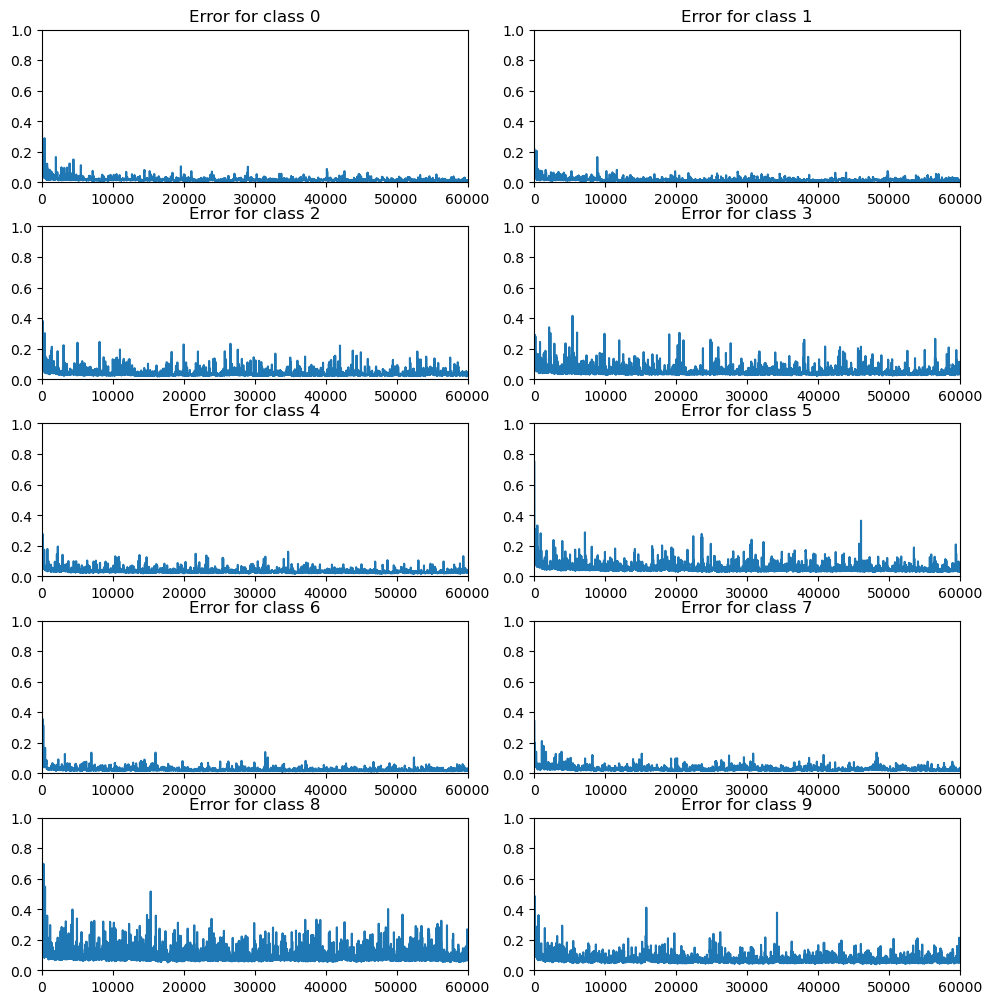

[0.0078125  0.00614583 0.01875    0.02458333 0.016875   0.02739583
 0.01114583 0.0140625  0.05114583 0.03947917]


In [32]:
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

In [33]:
end_time - start_time

106.0100269317627

In [34]:
predictions = model.predict(X_test)
predictions

array([9, 6, 1, ..., 6, 5, 4])

In [35]:
model.accuracy(predictions, y_test)

0.8949

In [36]:
# with open('model_weights.npy', 'wb') as f:
#     np.save(f, model.weights)

In [37]:
# TODO: discuss about the results, overall performance and effectiveness (time complexity wise and actual usage)

In [38]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(weights, i, x):
    return np.exp(weights[i].dot(x.T)) / np.sum(np.exp(weights.dot(x.T)), axis=0)

# inheriting from the perceptron class to use the predict and metrics methods
class LogisticRegression(Perceptron):

    def __init__(self, num_features, classes, learning_rate=0.01, epochs=1):
        # initializing variables like the perceptron
        super().__init__(num_features=num_features, classes=classes, epochs=epochs)
        self.lr = learning_rate
        # setting every weight vector to be zero vector
        self.weights[True] = 0
        print(np.unique(self.weights))

    def fit(self, X_train, y_train):
        # setting the negative value to be zero for the indicator in the gradient calculation
        super().init_multi_class_labels(y_train=y_train, negative_value=0)

        # need gradients to be of shape (self.num_classes, self.num_features)
        # where gradients[i] = sum((softmax(w_i, x_n) - I[y_n = i]) * x_n)
        for epoch in range(self.epochs):
            # shape = (num_classes x num_samples)
            # row i refers to the exponent of w_i with all the samples
            weights_X_exp = np.exp(self.weights @ X_train.T)
            
            # need to divide weights_X_exp by the sum of all exponents of the weight vectors by the samples
            # to divide each e^(w_i.T dot x) by sum(e^(w_j.T dot x) for 1<=j<=num_classes).
            # referring self.labels as the indicator in the gradient.
            # multiplying every result by the matching sample.
            gradients = np.sum(((weights_X_exp / np.sum(weights_X_exp, axis=0)) - self.labels)[:, :, np.newaxis] \
                               * X_train, axis=1)
            # making the weight vectors to go in the opposite direction of the matching gradient self.lr "steps"
            self.weights -= self.lr * gradients
            

In [39]:
logistic_regression = LogisticRegression(X.shape[1], np.unique(y), learning_rate=1, epochs=5)

[0.]


In [40]:
start_time = time.time()
logistic_regression.fit(X_train, y_train)
end_time = time.time()
end_time - start_time

[[ -20.    0.    0. ...    0.    0.    0.]
 [ 771.    0.    0. ...    0.    0.    0.]
 [ -46.    0.    0. ...    0.    0.    0.]
 ...
 [ 243.    0.    0. ...    0.    0.    0.]
 [-126.    0.    0. ...    0.    0.    0.]
 [ -26.    0.    0. ...    0.    0.    0.]]


/var/folders/yb/93ydr7mj7pv2zkq6wl0yl4th0000gn/T/ipykernel_10376/1215311058.py:27: RuntimeWarning: overflow encountered in exp
  weights_X_exp = np.exp(self.weights @ X_train.T)
/var/folders/yb/93ydr7mj7pv2zkq6wl0yl4th0000gn/T/ipykernel_10376/1215311058.py:33: RuntimeWarning: invalid value encountered in divide
  gradients = np.sum(((weights_X_exp / np.sum(weights_X_exp, axis=0)) - self.labels)[:, :, np.newaxis] \


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


4.990428924560547

In [41]:
predictions = logistic_regression.predict(X_test)

In [42]:
print(np.unique(predictions))
predictions

[0]


array([0, 0, 0, ..., 0, 0, 0])

In [43]:
logistic_regression.accuracy(predictions, y_test)

0.0923